# Generate datasets for TSP.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

from modules.helper_functions_tsp import(find_problem_size, 
                                         convert_integer_to_binary_list,
                                         read_file_name, 
                                         validate_distance_array, 
                                         cost_fn_fact, 
                                         convert_bit_string_to_cycle,
                                         hot_start, 
                                         load_dict_from_json
                                         )

from modules.graph_functions import (plot_shortest_routes)

from modules.config import DATA_SOURCES, NETWORK_DIR

In [2]:
LOCATIONS = 12
GRID_SIZE = 100
WRITE_DATA = True               #save data to disk
READ_DATA = False               #read pre-written data

In [3]:
if READ_DATA:
    if WRITE_DATA:
        raise Exception('Do not read and write data')

In [4]:
filename1 = f'sim_dist_{LOCATIONS}_locs.txt'
filename2 = f'sim_points_{LOCATIONS}_locs.txt'

filepath1 = Path(NETWORK_DIR).joinpath(filename1)
filepath2 = Path(NETWORK_DIR).joinpath(filename2)

filepath_json = Path(NETWORK_DIR).joinpath(DATA_SOURCES)

In [5]:
data_source_dict = load_dict_from_json(filepath_json)

In [6]:
if str(LOCATIONS) in data_source_dict:
    source = data_source_dict[str(LOCATIONS)]['source']
    if source != 'sim':
        raise Exception(f'Cannot read data for datasource type {source} as no co-ordinate data')

Generate random position

In [7]:
if not(READ_DATA):
    np.random.seed(42)
    points = np.random.uniform(0, GRID_SIZE, size=(LOCATIONS,2))
    print(points)

[[37.45401188 95.07143064]
 [73.19939418 59.86584842]
 [15.60186404 15.59945203]
 [ 5.80836122 86.61761458]
 [60.11150117 70.80725778]
 [ 2.05844943 96.99098522]
 [83.24426408 21.23391107]
 [18.18249672 18.34045099]
 [30.4242243  52.47564316]
 [43.19450186 29.12291402]
 [61.18528947 13.94938607]
 [29.21446485 36.63618433]]


Function module to find distance between points

In [8]:
def find_distance(points: np.array, point1:int, point2:int)->float:
    dist = np.linalg.norm(points[point1] - points[point2])
    return round(dist, 1)

Calculate and print the district array:

In [9]:
if not(READ_DATA):
    distance_array = np.zeros((LOCATIONS, LOCATIONS))
    for i in range(LOCATIONS):
        for j in range(LOCATIONS):
            distance_array[i][j] = find_distance(points, i , j)
    print(distance_array)

[[  0.   50.2  82.4  32.8  33.2  35.4  86.9  79.1  43.2  66.2  84.5  59. ]
 [ 50.2   0.   72.6  72.5  17.1  80.2  39.9  68.9  43.4  43.   47.5  49.7]
 [ 82.4  72.6   0.   71.7  70.9  82.5  67.9   3.8  39.7  30.7  45.6  25.1]
 [ 32.8  72.5  71.7   0.   56.6  11.  101.3  69.4  42.1  68.6  91.4  55.2]
 [ 33.2  17.1  70.9  56.6   0.   63.7  54.7  67.2  34.9  45.   56.9  46.1]
 [ 35.4  80.2  82.5  11.   63.7   0.  111.   80.3  52.8  79.4 101.9  66.2]
 [ 86.9  39.9  67.9 101.3  54.7 111.    0.   65.1  61.4  40.8  23.2  56.2]
 [ 79.1  68.9   3.8  69.4  67.2  80.3  65.1   0.   36.3  27.2  43.2  21.4]
 [ 43.2  43.4  39.7  42.1  34.9  52.8  61.4  36.3   0.   26.6  49.3  15.9]
 [ 66.2  43.   30.7  68.6  45.   79.4  40.8  27.2  26.6   0.   23.5  15.9]
 [ 84.5  47.5  45.6  91.4  56.9 101.9  23.2  43.2  49.3  23.5   0.   39.2]
 [ 59.   49.7  25.1  55.2  46.1  66.2  56.2  21.4  15.9  15.9  39.2   0. ]]


Function module to write data:

In [10]:
def write_data(list: list, filepath: str):
    """Open a file in write mode"""
    if WRITE_DATA:
        with open(filepath, 'w') as file:
            for rows in list:
                line = ''
                for i, item in enumerate(rows):
                    line += str(item)
                    if i < len(rows):
                        line += '\t'
                file.write(line + '\n')

        print(f'Data has been written to {filepath}')
    else:
        print('WRITE_DATA is not set')

If existing data is to be read get from file:

In [11]:
if READ_DATA:
    data_filename = read_file_name(str(LOCATIONS), data_source_dict)
    data_filepath = Path(NETWORK_DIR).joinpath(data_filename)
    best_dist = data_source_dict[str(LOCATIONS)]['best']
    
    print(f'Distance data will be read from filepath {data_filepath}.  It is known that the shortest distance is {best_dist}.')
    distance_array = np.genfromtxt(data_filepath)
    validate_distance_array(distance_array, LOCATIONS)
    points_filename = read_file_name(str(LOCATIONS), data_source_dict, file_type='points')
    points_filepath = Path(NETWORK_DIR).joinpath(points_filename)

    print(f'The co-ordinates of locations will be read from {points_filepath}')
    points = np.genfromtxt(points_filepath)
else:
    print('Calculated data will be used')

Calculated data will be used


Plot points:

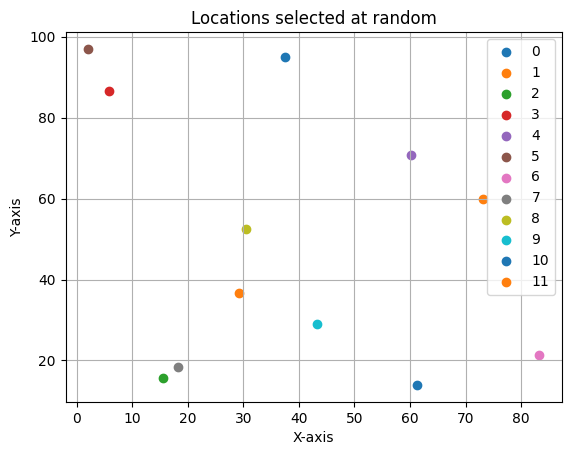

In [12]:
for i in range(LOCATIONS):
    plt.scatter(points[i, 0], points[i, 1], marker='o', label=i)

plt.legend()
plt.title('Locations selected at random')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

Find problem size:

In [13]:
qubits = find_problem_size(LOCATIONS, 'original')
print(f'There are {qubits} qubits needed for {LOCATIONS} locations in the orig formulation.')

There are 29 qubits needed for 12 locations in the orig formulation.


Find cost function and calculate lowest distance by evaluating for every possible binary string

In [14]:
cost_fn = cost_fn_fact(LOCATIONS, distance_array)
lowest_to_date = LOCATIONS*2 * 100 #to high
for integer in range(2**qubits):
    binary_string_list = convert_integer_to_binary_list(integer, length=qubits, gray=False)
    cost = cost_fn(binary_string_list)
    if cost < lowest_to_date:
        lowest_to_date = cost
        route_string = binary_string_list
route1 = convert_bit_string_to_cycle(route_string, LOCATIONS)
print(f'The lowest distance found by a brute force search is {lowest_to_date} with route list = {route1}')

The lowest distance found by a brute force search is 297.2 with route list = [0, 4, 1, 6, 10, 9, 2, 7, 11, 8, 3, 5]


Evaluate hot start route:

In [15]:
#hot start route
route2 = hot_start(distance_array, LOCATIONS)
print(f'The hot start route is {route2}')

The hot start route is [0, 3, 5, 8, 11, 9, 10, 6, 1, 4, 7, 2]


Plot shortest route, and hot_start_route

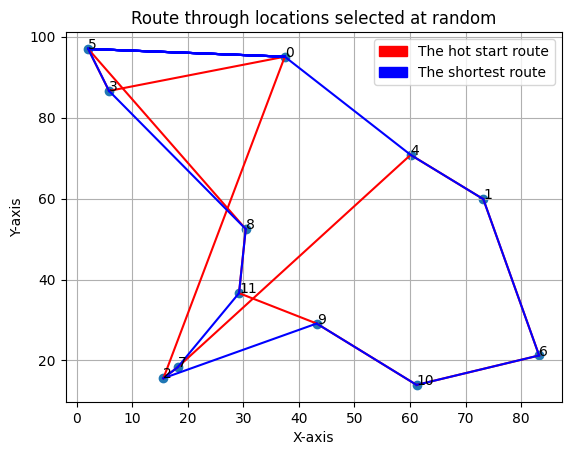

In [16]:
plot_shortest_routes(points, route1, route2)

Function to save data:

In [17]:
def save_dict_to_json(data, filename):
  with open(filename, 'w') as f:
    json.dump(data, f, indent=4)

Write data:

In [ ]:
if WRITE_DATA:
  if str(LOCATIONS) in data_source_dict:
    raise Exception('Data is already saved for {locations} locations')
  distances = []
  for i in range(LOCATIONS):
    distance_row = []
    for j in range(LOCATIONS):
      distance_row.append(str(distance_array[i][j]))
    distances.append(distance_row)
  else:
    write_data(distances, filepath1)
    points_list = points.tolist()
    write_data(points_list, filepath2)
    key = str(LOCATIONS)
    data_source_dict[key] = {}
    data_source_dict[key]['file'] = filename1
    data_source_dict[key]['best'] = lowest_to_date
    data_source_dict[key]['source'] = 'sim'
    data_source_dict[key]['points'] = filename2
    save_dict_to_json(data_source_dict, filepath_json)
    
else:
  print('WRITE_DATA is not set')

Data has been written to networks\sim_dist_12_locs.txt
Data has been written to networks\sim_points_12_locs.txt
